# Track Hub Usage Activity with Grafana

This notebook follows the guidance in GitHub issue [2i2c-org/infrastructure/#1785](https://github.com/2i2c-org/infrastructure/issues/1785) for tracking hub usage activity with Grafana. We implement this specifically for Catalyst Project clusters.

Grafana is an open source analytics and interactive visualization web application. Prometheus is an open-source monitoring and alerting platform that collects and stores metrics as time-series data, which feeds into the Grafana as a data source.

Deployments for 2i2c hubs (k8s+JupyterHub) follow the GitHub repository [jupyterhub/grafana-dashboards](https://github.com/jupyterhub/grafana-dashboards).

---

In [1]:
!pip install -r requirements.txt

  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached dateparser-1.2.0-py2.py3-none-any.whl.metadata (28 kB)
  Using cached prometheus_pandas-0.3.3-py3-none-any.whl.metadata (3.0 kB)
  Using cached plotly-5.21.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached regex-2024.4.16-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tzlocal-5.2-py3-none-any.whl.metadata (7.8 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
Using cached dateparser-1.2.0-py2.py3-none-any.whl (294 kB)
Using cached prometheus_pandas-0.3.3-py3-none-any.whl (6.1 kB)
Using cached plotly-5.21.0-py3-none-any.whl (15.7 MB)
Using cached regex-2024.4.16-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (785 kB)
Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
Using cached tzlocal-5.2-py3-none-any.whl (17 kB)


In [2]:
import os
import requests
from dotenv import load_dotenv
from urllib.parse import urlencode
from datetime import datetime
from dateparser import parse as dateparser_parse
from prometheus_pandas.query import Prometheus
import pandas as pd
import plotly.graph_objects as go

pd.options.plotting.backend = "plotly"

Create a [Grafana service account](https://grafana.com/docs/grafana/latest/administration/service-accounts/) and generate a token to authenticate with the Grafana API. This is stored as an environment variable in a `.env` file.

In [3]:
load_dotenv()
GRAFANA_TOKEN = os.environ["GRAFANA_TOKEN"]

In [4]:
def get_default_prometheus_uid(grafana_url: str, grafana_token: str, hub_name: str) -> str:
    """
    Get the uid of the default prometheus configured for this grafana

    grafana_url is the base URL of the grafana to talk to. It must have
    a trailing slash.

    grafana_token is a service account token with appropriate rights
    to make this API call
    """
    api_url = f"{grafana_url}/api/datasources"
    datasources = requests.get(
        api_url,
        headers={
            "Accept": "application/json",
            "Content-Type": "application/json",
            "Authorization": f"Bearer {grafana_token}",
        }
    ).json()
    for ds in datasources:
        if ds["type"] == "prometheus" and ds["name"] == hub_name:
            return ds["uid"]

In [5]:
def query_prometheus(
    grafana_url: str,
    grafana_token: str,
    prometheus_uid: str,
    query: str,
    start_time: datetime,
    end_time: datetime,
    step: int,
):
    """
    Query data from prometheus & return responses

    Args:
        grafana_url (str): URL of Grafana to use to query. Must end in a trailing slash
        grafana_token (str): Token of grafana service account with Viewer permissions to use
        prometheus_uid (str): uid of prometheus datasource within grafana to query
        query (str): Prometheus query to execute
        start_time (datetime): Start time to run this query from
        end_time (datetime): End time to run this query till
        step (int): Steps (in seconds) to execute this query, starting from start_time until end_time

    Returns:
        Query responses, in the [range vector format](https://prometheus.io/docs/prometheus/latest/querying/api/#range-vectors)
        [
            {"metric": {<metric-info>}, "values": [[timestamp, value], [timestamp, value]...]},
            {"metric": {<metric-info>}, "values": [[timestamp, value], [timestamp, value]...]}
        ]
    """
    params = {
        "query": query,
        "start": start_time.timestamp(),
        "end": end_time.timestamp(),
        "step": step,
    }
    proxy_url = f"{grafana_url}/api/datasources/proxy/uid/{prometheus_uid}/api/v1/query_range?{urlencode(params)}"

    resp = requests.post(
        proxy_url, headers={"Authorization": f"Bearer {grafana_token}"}
    )
    import json

    return json.dumps(resp.json()["data"]["result"], indent=2)

In [6]:
def get_pandas_prometheus(grafana_url: str, grafana_token: str, prometheus_uid: str):
    """
    
    """
    session = requests.Session()
    session.headers = {"Authorization": f"Bearer {grafana_token}"}

    proxy_url = f"{grafana_url}/api/datasources/proxy/uid/{prometheus_uid}/"
    return Prometheus(proxy_url, session)

Obtain the unique IDs of the data sources for `catalystproject-africa` and `catalystproject-latam`.

In [7]:
hub_list = ["catalystproject-africa", "catalystproject-latam"]
prometheus_uid = [get_default_prometheus_uid(
    "https://grafana.pilot.2i2c.cloud", GRAFANA_TOKEN, hub
) for hub in hub_list]

Call the `get_pandas_prometheus()` function.

In [8]:
prometheus = [get_pandas_prometheus(
    "https://grafana.pilot.2i2c.cloud", GRAFANA_TOKEN, uid
) for uid in prometheus_uid]

Define a query for the data source using [PromQL](https://prometheus.io/docs/prometheus/latest/querying/basics/), formatted as a string.

In [9]:
query = """
        max(
          jupyterhub_active_users{period="24h", namespace=~".*"}
        ) by (namespace)
        """

Evaluate the query and output to a pandas dataframe.

In [10]:
dfs = [p.query_range(
    query,
    dateparser_parse("6 months ago"),
    dateparser_parse("now"),
    "1d",
) for p in prometheus]

Round datetime index to nearest calendar day

In [56]:
dfs[0].index = dfs[0].index.floor('D')
dfs[1].index = dfs[1].index.floor('D')

Rename hubs to a human readable format.

In [57]:
hub_names = [
    [
        "AIBST",
        "BHKI",
        "BON",
        "Kush",
        "MolerHealth",
        "MUST",
        "NM-AIST",
        "Staging",
        "UVRI",
        "Witwatersrand",
    ],
    [
        "CICADA",
        "GITA",
        "Staging",
        "UNITEFA"
    ]
]

dfs = [df.rename(columns=dict(zip(df.columns, name))) for (df, name) in zip(dfs, hub_names)]

Plot the data.

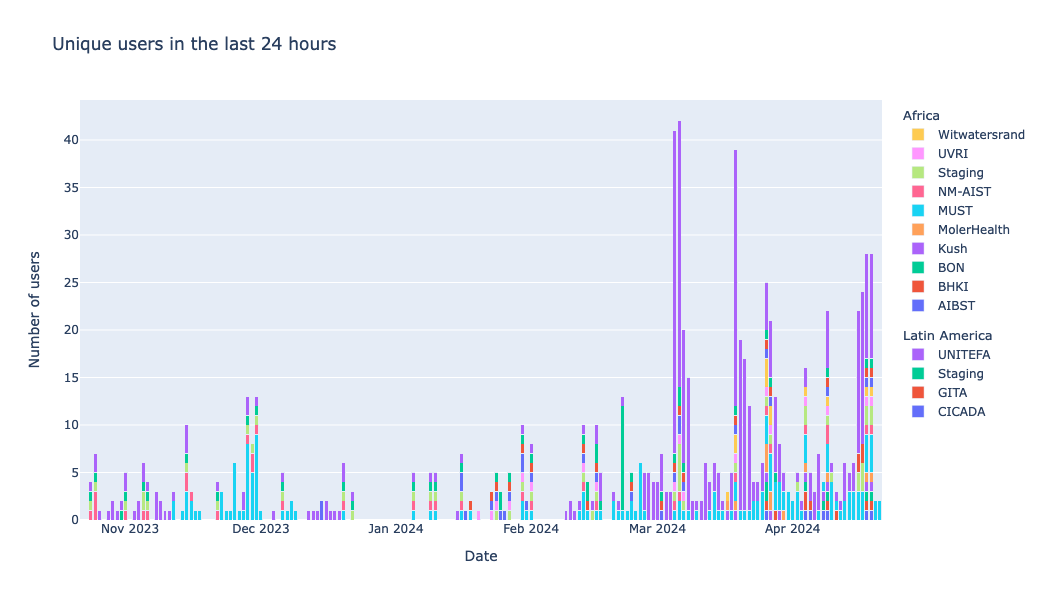

In [69]:
fig = go.Figure()
for col in dfs[0].columns:
    fig.add_trace(go.Bar(
        x=dfs[0].index,
        y=dfs[0][col],
        legendgrouptitle_text="Africa",
        legendgroup="africa",
        name=f"{col}",
        )
    )
for col in dfs[1].columns:
    fig.add_trace(go.Bar(
        x=dfs[1].index,
        y=dfs[1][col],
        legendgrouptitle_text="Latin America",
        legendgroup="latam",
        name=f"{col}",
        )
    )
fig.update_layout(
    title_text="Unique users in the last 24 hours",
    xaxis_title="Date",
    yaxis_title="Number of users",
    width=1024,
    height=600,
    legend=dict(groupclick="toggleitem"),
    barmode='stack',
    )
fig.show()